In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Task 1 fully connected feed-forward network

In [48]:
# Stellar Classification Dataset - SDSS17
# dataset url: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17?resource=download
dataset_relative_path = "star_classification.csv"
df = pd.read_csv(dataset_relative_path)


# Значення -9999.000000 в u, g, z явно вказує на наявність значення NO DATA, оскільки ці показники не можуть приймати таке значення
df = df.drop(df[df["u"] == -9999.0].index)
df = df.drop(df[df["g"] == -9999.0].index)
df = df.drop(df[df["z"] == -9999.0].index)
df.describe()


# obj_ID, alpha, delta, run_ID, rerun_ID, spec_obj_ID, field_ID - не можуть впливати на класифікацію
df = df.drop(columns=["obj_ID", "alpha", "delta", "run_ID", "rerun_ID", "spec_obj_ID", "field_ID"], errors='ignore')
df.head()


remap_dict = {"GALAXY": 0, "QSO": 1, "STAR": 2}
df["class"].update(df["class"].map(remap_dict))
df = df.astype({"class": "int64"})
df.head()

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df["class"]
X = df.drop(["class"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
un_values, un_count = np.unique(y_train, return_counts=True)
un_weight = 1 / un_count
print(un_weight)

[2.40269101e-05 7.53806724e-05 6.61681996e-05]


In [50]:
print(X_train.shape)

(69999, 10)


In [74]:
model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),    
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='sigmoid'),
    ])

model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 32)                352       
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_43 (Dense)            (None, 16)                528       
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_44 (Dense)            (None, 3)                 51        
                                                                 
Total params: 931
Trainable params: 931
Non-trainable params: 0
_________________________________________________________________


In [78]:
history = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=X_train.shape[0],                                   
                    validation_split=0.2,
                    verbose=2,)
                    # class_weight={0:un_weight[0], 1:un_weight[1], 2:un_weight[2]})

Epoch 1/2000


1/1 - 0s - loss: 0.6767 - accuracy: 0.7137 - val_loss: 0.6156 - val_accuracy: 0.7392 - 163ms/epoch - 163ms/step
Epoch 2/2000
1/1 - 0s - loss: 0.6761 - accuracy: 0.7149 - val_loss: 0.6144 - val_accuracy: 0.7394 - 70ms/epoch - 70ms/step
Epoch 3/2000
1/1 - 0s - loss: 0.6742 - accuracy: 0.7158 - val_loss: 0.6131 - val_accuracy: 0.7396 - 71ms/epoch - 71ms/step
Epoch 4/2000
1/1 - 0s - loss: 0.6727 - accuracy: 0.7151 - val_loss: 0.6119 - val_accuracy: 0.7398 - 63ms/epoch - 63ms/step
Epoch 5/2000
1/1 - 0s - loss: 0.6704 - accuracy: 0.7153 - val_loss: 0.6106 - val_accuracy: 0.7399 - 63ms/epoch - 63ms/step
Epoch 6/2000
1/1 - 0s - loss: 0.6717 - accuracy: 0.7169 - val_loss: 0.6094 - val_accuracy: 0.7400 - 70ms/epoch - 70ms/step
Epoch 7/2000
1/1 - 0s - loss: 0.6701 - accuracy: 0.7173 - val_loss: 0.6081 - val_accuracy: 0.7404 - 68ms/epoch - 68ms/step
Epoch 8/2000
1/1 - 0s - loss: 0.6689 - accuracy: 0.7180 - val_loss: 0.6069 - val_accuracy: 0.7405 - 74ms/epoch - 74ms/step
Epoch 9/2000
1/1 - 0s - los

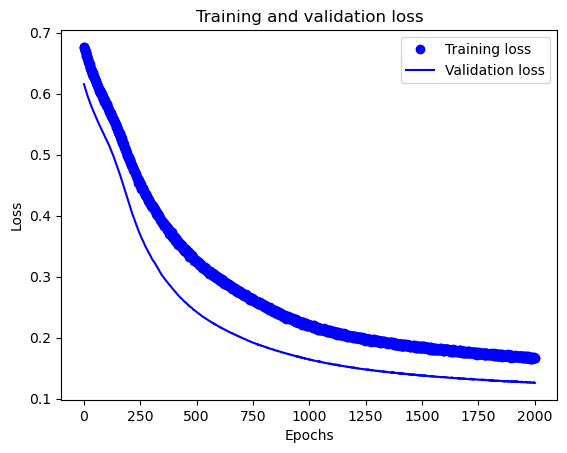

In [79]:
history_dict = history.history
history_dict.keys()

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [80]:
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.12620171904563904
Test accuracy: 0.9632666707038879


# Task 2: CNN

In [211]:
import os
import random
import shutil

def img_train_test_split_bicycle(src_folder, dst_folder, train_part):
    files = list(os.listdir(src_folder))
    random.shuffle(files)
    length = int(train_part * len(files))

    for file in files[:length]:
        shutil.copy(os.path.join(src_folder, file), os.path.join("train", dst_folder, file))

    for file in files[length:]:
        shutil.copy(os.path.join(src_folder, file), os.path.join("test", dst_folder, file))

def plot_history(history, start_from = 0):
    history_dict = history.history
    history_dict.keys()

    history_dict = history.history
    loss_values = history_dict["loss"][start_from:]
    # val_loss_values = history_dict["val_loss"][start_from:]

    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, "bo", label="Training loss")
    # plt.plot(epochs, val_loss_values, "b", label="Validation loss")

    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [6]:
# Dataset: Multi-class Weather Dataset https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset

# img_train_test_split_bicycle("Multi-class Weather Dataset\Cloudy", "Cloudy", 0.8)
# img_train_test_split_bicycle("Multi-class Weather Dataset\Rain", "Rain", 0.8)
# img_train_test_split_bicycle("Multi-class Weather Dataset\Shine", "Shine", 0.8)
# img_train_test_split_bicycle("Multi-class Weather Dataset\Sunrise", "Sunrise", 0.8)

In [74]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=512,
    image_size=(32, 32))

validation_ds = keras.utils.image_dataset_from_directory(
    directory='test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=512,
    image_size=(32, 32))

Found 953 files belonging to 4 classes.


Found 280 files belonging to 4 classes.


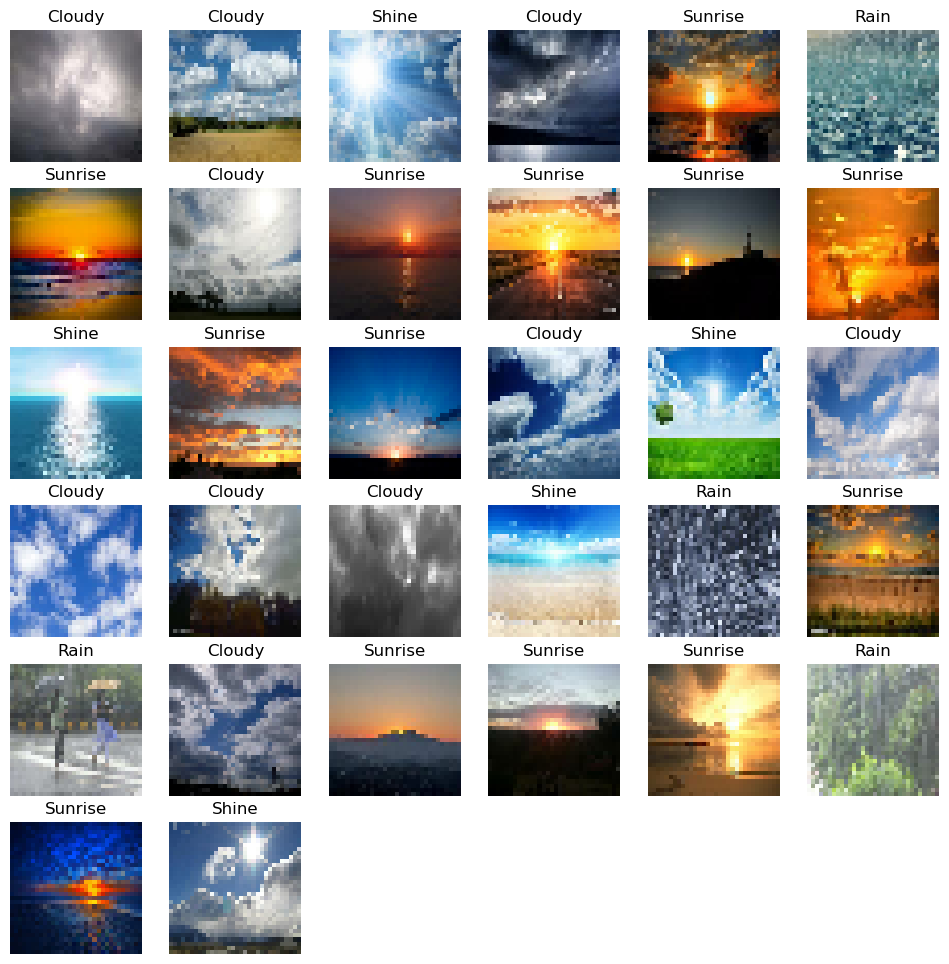

In [75]:
class_names = ["Cloudy", "Rain", "Shine", "Sunrise"]

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [76]:
model =  keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 dropout_14 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_7 (Flatten)         (None, 9216)              0         
                                                                 
 dense_14 (Dense)            (None, 16)                147472    
                                                     

In [77]:
history = model.fit(train_ds, epochs=100, verbose=1, validation_data=validation_ds)

Epoch 1/100


2/2 [==============================] - 4s 978ms/step - loss: 105.9200 - accuracy: 0.2487 - val_loss: 83.4262 - val_accuracy: 0.1821
Epoch 2/100
2/2 [==============================] - 3s 830ms/step - loss: 67.9914 - accuracy: 0.2256 - val_loss: 15.5612 - val_accuracy: 0.1643
Epoch 3/100
2/2 [==============================] - 3s 722ms/step - loss: 13.6695 - accuracy: 0.2403 - val_loss: 1.3289 - val_accuracy: 0.3929
Epoch 4/100
2/2 [==============================] - 3s 700ms/step - loss: 3.2197 - accuracy: 0.3694 - val_loss: 2.8775 - val_accuracy: 0.2571
Epoch 5/100
2/2 [==============================] - 3s 789ms/step - loss: 2.0219 - accuracy: 0.2980 - val_loss: 1.3462 - val_accuracy: 0.2571
Epoch 6/100
2/2 [==============================] - 3s 749ms/step - loss: 1.3471 - accuracy: 0.2991 - val_loss: 1.3859 - val_accuracy: 0.4071
Epoch 7/100
2/2 [==============================] - 3s 700ms/step - loss: 1.3792 - accuracy: 0.3137 - val_loss: 1.3857 - val_accuracy: 0.4071
Epoch 8/100
2/2 [==

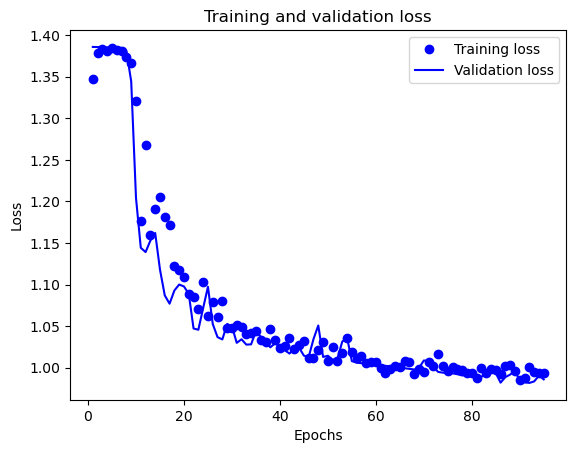

In [80]:
plot_history(history, 5)

In [79]:
import sklearn.metrics as metrics

y_true = []
y_pred = []
for x,y in validation_ds:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(model.predict(x),axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

result = metrics.confusion_matrix(y_true, y_pred)
print(result)

9/9 [==============================] - 0s 7ms/step
[[114   0   0   0]
 [ 43   0   0   0]
 [ 51   0   0   0]
 [  1   0   0  71]]


# Task 3: LSTM

In [82]:
# Trip Advisor Hotel Reviews
# dataset url: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

reviews = pd.read_csv("tripadvisor_hotel_reviews.csv")
reviews.head() 

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [83]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import re
import string

In [84]:
lemmatizer = WordNetLemmatizer()

print(reviews.shape)
reviews = reviews.reset_index()
filtered_reviews = [None]*reviews.shape[0]

for i, row in reviews.iterrows():
    text = row.Review
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    tokens = word_tokenize(text)
    stop_words = stopwords.words('english')

    counter = 0
    filtered = [None]*len(tokens)
    for word in tokens:
        if word not in stop_words:
            filtered[counter] = word
            counter += 1

    filtered = filtered[:counter]
    lemmatized = [lemmatizer.lemmatize(t) for t in filtered]
    filtered_reviews[i] = ' '.join(lemmatized)

reviews.Reviews = filtered_reviews

(20491, 2)


C:\Users\yevhe\AppData\Local\Temp\ipykernel_19304\825857867.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  reviews.Reviews = filtered_reviews


In [203]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews.Review, reviews.Rating, train_size=0.5)

y_train = tf.one_hot(y_train - 1, 5)
y_test = tf.one_hot(y_test - 1, 5)

In [204]:
max_features = 10000
sequence_length = 120

In [205]:
tokenize = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenize.fit_on_texts(X_train)
X_train = tokenize.texts_to_sequences(X_train)
X_test = tokenize.texts_to_sequences(X_test)

X_train = keras.utils.pad_sequences(X_train, maxlen=sequence_length)
X_test = keras.utils.pad_sequences(X_test, maxlen=sequence_length)

In [206]:
print(y_train)

tf.Tensor(
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]], shape=(10245, 5), dtype=float32)


In [207]:
model = keras.Sequential([
    layers.Embedding(max_features, 64),
    layers.LSTM(256),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dense(5, activation='sigmoid'),
])

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 64)          640000    
                                                                 
 lstm_34 (LSTM)              (None, 256)               328704    
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_40 (Dense)            (None, 16)                4112      
                                                                 
 dense_41 (Dense)            (None, 5)                 85        
                                                                 
Total params: 973,925
Trainable params: 973,413
Non-trainable params: 512
_____________________________________________

In [208]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0,
                    shuffle = True,
                    verbose = 1)

Epoch 1/20
81/81 [==============================] - 65s 767ms/step - loss: 0.4995 - accuracy: 0.4468
Epoch 2/20
81/81 [==============================] - 62s 768ms/step - loss: 0.3379 - accuracy: 0.6023
Epoch 3/20
81/81 [==============================] - 68s 839ms/step - loss: 0.2941 - accuracy: 0.6723
Epoch 4/20
81/81 [==============================] - 85s 1s/step - loss: 0.2111 - accuracy: 0.7769
Epoch 5/20
81/81 [==============================] - 61s 756ms/step - loss: 0.1554 - accuracy: 0.8570
Epoch 6/20
81/81 [==============================] - 62s 764ms/step - loss: 0.1153 - accuracy: 0.9018
Epoch 7/20
81/81 [==============================] - 73s 898ms/step - loss: 0.0846 - accuracy: 0.9340
Epoch 8/20
81/81 [==============================] - 79s 974ms/step - loss: 0.0728 - accuracy: 0.9460
Epoch 9/20
81/81 [==============================] - 66s 806ms/step - loss: 0.0494 - accuracy: 0.9688
Epoch 10/20
81/81 [==============================] - 61s 754ms/step - loss: 0.0369 - accuracy:

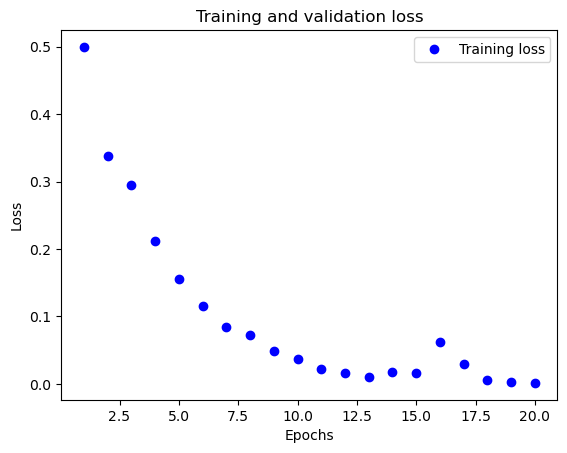

In [212]:
plot_history(history)

In [210]:
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(model.predict(X_test), axis=1)

result = metrics.confusion_matrix(y_true, y_pred)
print(result)

Test score: 1.379481554031372
Test accuracy: 0.4893617033958435
321/321 [==============================] - 43s 134ms/step
[[ 259  170  127   96   45]
 [ 157  200  229  248   77]
 [  66  138  284  442  159]
 [  50  116  295 1479 1066]
 [  31   54  156 1510 2792]]
